<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/5245hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# —— 作用：设置随机种子、选择设备（CPU/GPU），保证实验可复现 —— #

import os                         # 操作系统路径与环境变量
import random                     # Python 随机种子
import numpy as np                # 数值库，用于设随机种子
import torch                      # PyTorch 主库
import matplotlib.pyplot as plt   # 画图用
torch.backends.cudnn.benchmark = False  # 关闭 CUDNN 的基于输入的自动优化，以提升可复现性
torch.backends.cudnn.deterministic = True # 让 CUDNN 在卷积等选择确定性算法

SEED = 42                         # 设定一个常用的随机种子
random.seed(SEED)                 # Python 层面的随机性固定
np.random.seed(SEED)              # Numpy 层面的随机性固定
torch.manual_seed(SEED)           # CPU 上的随机性固定
torch.cuda.manual_seed_all(SEED)  # GPU（多卡）上的随机性固定

device = "cuda" if torch.cuda.is_available() else "cpu"  # 自动选择 GPU 或 CPU
print("Using device:", device)                           # 打印选择的设备


Using device: cuda


In [3]:
# —— 作用：下载 CIFAR-10 训练集与测试集；把像素转为 float32 且范围 [0,1]；测试集作为验证集 —— #
# —— 依据：题面 Q1(a) 要求:contentReference[oaicite:3]{index=3} —— #

import torch
from torchvision import datasets             # 提供 CIFAR-10 数据集
from torchvision.transforms import v2 as T   # 题面要求使用 transforms.v2

# 1) 指定数据下载的根目录（放在用户目录下更通用）
data_root = os.path.expanduser("~/data/cifar10")

# 2) 定义 transforms.v2 的显式流水线：ToImage 后再 ToDtype(float32, scale=True) 缩放到 [0,1]
to_01 = T.Compose([
    T.ToImage(),                            # PIL/ndarray -> 张量 (C,H,W), dtype=uint8,[0,255]
    T.ToDtype(torch.float32, scale=True),   # 转 float32 并缩放到 [0,1]
])

# 3) 构建训练集（train=True）并应用转换
train_set = datasets.CIFAR10(
    root=data_root,     # 下载根目录
    train=True,         # 选择训练划分（50,000）
    download=True,      # 若本地无缓存则自动下载
    transform=to_01,    # 转为 [0,1] 的 float32 张量
)

# 4) 构建测试集（将被当作验证集使用；题面明确说明）
val_set = datasets.CIFAR10(
    root=data_root,     # 同一根目录
    train=False,        # 选择测试划分（10,000）
    download=True,      # 自动下载
    transform=to_01,    # 同样转换到 [0,1]
)

# 5) 简要确认规模
print(f"Train size = {len(train_set)}, Val size = {len(val_set)}")


100%|██████████| 170M/170M [01:57<00:00, 1.45MB/s]


Train size = 50000, Val size = 10000


In [9]:
# —— 作用：构建训练与验证 DataLoader；训练批量=128；验证批量自定 —— #
# —— 依据：题面 Q1(b) 要求:contentReference[oaicite:4]{index=4} —— #

from torch.utils.data import DataLoader  # PyTorch 数据管道

# 1) 设定批量大小（遵循题面：训练=128；验证可自定设 256）
batch_size_train = 128
batch_size_val   = 256

# 2) 构建训练 DataLoader（打乱以提升泛化；pin_memory 对 GPU 更快）
train_loader = DataLoader(
    dataset=train_set,          # 数据集对象
    batch_size=batch_size_train,# 每个小批的样本数
    shuffle=True,               # 训练集需要打乱
    num_workers=2,              # 数据加载线程数；Windows 可设 0
    pin_memory=True             # 若 GPU 训练，可加速主存->显存拷贝
)

# 3) 构建验证 DataLoader（不打乱，便于可重复验证）
val_loader = DataLoader(
    dataset=val_set,            # 验证（实际是测试集）
    batch_size=batch_size_val,  # 验证批量可更大以提高效率
    shuffle=False,              # 验证集不需要打乱
    num_workers=2,
    pin_memory=True
)

# 4) 取一个 batch 快速检验维度
xb, yb = next(iter(train_loader))        # 从训练加载器里取第一批
print("Train batch:", xb.shape, yb.shape) # 期望 [128, 3, 32, 32] 与 [128]


Train batch: torch.Size([128, 3, 32, 32]) torch.Size([128])


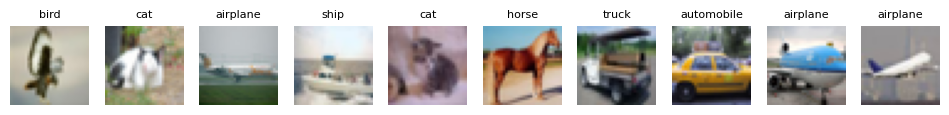

In [10]:
# —— 作用：可视化前 10 张训练图像（来自第一个 batch）并显示类别名 —— #
# —— 依据：题面 Q1(c) 要求:contentReference[oaicite:5]{index=5} —— #

# 1) CIFAR-10 的 10 个类别名（官方顺序）
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# 2) 从第一个训练 batch 中取图像与标签
images, labels = next(iter(train_loader)) # images: [B,3,32,32], labels: [B]
images = images[:10]                      # 仅取前 10 张
labels = labels[:10]                      # 对应前 10 个标签

# 3) 绘制 1×10 的子图网格
plt.figure(figsize=(12, 2))               # 画布大小
for i in range(10):                       # 逐个绘制
    img = images[i].permute(1, 2, 0).numpy() # (C,H,W)->(H,W,C) 以便 imshow
    plt.subplot(1, 10, i+1)               # 放在第 i+1 个子图里
    plt.imshow(img)                       # 显示图片
    plt.axis("off")                       # 不显示坐标轴
    plt.title(classes[labels[i]], fontsize=8) # 上方显示类别名
plt.show()                                # 展示


In [11]:
# —— 作用：实现 train_one_epoch() 与 evaluate()，训练 1 轮/评估 1 次 —— #
# —— 依据：题面 Q1(d) 给出的函数签名与行为:contentReference[oaicite:6]{index=6} —— #

import torch.nn as nn
import torch.optim as optim

def train_one_epoch(dataloader, model, loss_fn, optimizer, device=device):
    """
    单轮训练：遍历 dataloader，梯度清零 -> 前向 -> 反向 -> 更新，并累计平均损失/准确率
    """
    model.train()                       # 进入训练模式（启用 Dropout/BN 的训练行为）
    total_loss, total_correct = 0.0, 0  # 用于累计损失与正确样本数
    total_count = 0                     # 累计样本总数
    for X, y in dataloader:            # 逐 batch 取数据
        X, y = X.to(device), y.to(device)  # 把数据移到 GPU/CPU

        logits = model(X)                  # 前向传播，得到 [B,10] 的 logits
        loss = loss_fn(logits, y)          # 计算交叉熵损失

        optimizer.zero_grad()              # 每步前都清零梯度
        loss.backward()                    # 反向传播，计算梯度
        optimizer.step()                   # 用优化器更新参数

        total_loss   += loss.item() * X.size(0)                 # 累计“总损失”
        total_correct+= (logits.argmax(1) == y).sum().item()    # 累计“预测正确数”
        total_count  += X.size(0)                                # 累计样本总数

    avg_loss = total_loss / total_count      # 计算平均损失
    avg_acc  = total_correct / total_count   # 计算平均准确率
    return avg_loss, avg_acc                 # 返回单轮的训练均值

@torch.no_grad()                              # 评估时不需要梯度，节省显存/加速
def evaluate(dataloader, model, loss_fn, device=device):
    """
    验证评估：不更新参数，仅计算平均损失与准确率
    """
    model.eval()                              # 进入评估模式（禁用 Dropout/使用 BN 的推理均值方差）
    total_loss, total_correct = 0.0, 0
    total_count = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)                     # 前向
        loss = loss_fn(logits, y)             # 损失
        total_loss   += loss.item() * X.size(0)
        total_correct+= (logits.argmax(1) == y).sum().item()
        total_count  += X.size(0)

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc


In [12]:
# —— 作用：定义基线 CNN 并按题面配置训练 20 轮，收集曲线 —— #
# —— 依据：题面 Q1(A) 的结构与训练设置:contentReference[oaicite:8]{index=8} —— #

class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0), # 3→16，3×3 无填充
            nn.ReLU(),                                            # ReLU 激活
            nn.MaxPool2d(2, 2),                                   # 2×2 池化，步长2

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),# 16→32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),# 32→32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 2 * 2, 64),  # 展平维度=32×2×2=128 → 64（题面要求“From 128 to 64”）
            nn.ReLU(),
            nn.Linear(64, 10)           # 64 → 10 类别 logits
        )

    def forward(self, x):
        x = self.feat(x)               # 卷积与池化特征
        x = x.view(x.size(0), -1)      # 展平为二维 [B, 128]
        x = self.fc(x)                 # 全连接头部
        return x

# 1) 实例化模型、损失、优化器（题面要求：CrossEntropyLoss + Adam 默认）
model_A = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters())

# 2) 训练 20 轮并收集指标
EPOCHS = 20
A_train_losses, A_val_losses, A_val_accs = [], [], []

for ep in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(train_loader, model_A, criterion, optimizer_A, device)
    va_loss, va_acc = evaluate(val_loader, model_A, criterion, device)
    A_train_losses.append(tr_loss)
    A_val_losses.append(va_loss)
    A_val_accs.append(va_acc)
    print(f"[A] Epoch {ep+1:02d}/{EPOCHS} | TrainLoss {tr_loss:.4f} | ValLoss {va_loss:.4f} | ValAcc {va_acc:.4f}")

print("Baseline (A) 训练完成 ✅")


[A] Epoch 01/20 | TrainLoss 1.8864 | ValLoss 1.6750 | ValAcc 0.3850
[A] Epoch 02/20 | TrainLoss 1.5797 | ValLoss 1.4985 | ValAcc 0.4537
[A] Epoch 03/20 | TrainLoss 1.4667 | ValLoss 1.4140 | ValAcc 0.4854
[A] Epoch 04/20 | TrainLoss 1.3893 | ValLoss 1.4003 | ValAcc 0.4983
[A] Epoch 05/20 | TrainLoss 1.3336 | ValLoss 1.3075 | ValAcc 0.5301
[A] Epoch 06/20 | TrainLoss 1.2792 | ValLoss 1.2645 | ValAcc 0.5457
[A] Epoch 07/20 | TrainLoss 1.2341 | ValLoss 1.2637 | ValAcc 0.5517
[A] Epoch 08/20 | TrainLoss 1.1975 | ValLoss 1.2616 | ValAcc 0.5509
[A] Epoch 09/20 | TrainLoss 1.1629 | ValLoss 1.1923 | ValAcc 0.5748
[A] Epoch 10/20 | TrainLoss 1.1327 | ValLoss 1.1574 | ValAcc 0.5889
[A] Epoch 11/20 | TrainLoss 1.1071 | ValLoss 1.1416 | ValAcc 0.5942
[A] Epoch 12/20 | TrainLoss 1.0759 | ValLoss 1.1674 | ValAcc 0.5874
[A] Epoch 13/20 | TrainLoss 1.0602 | ValLoss 1.1067 | ValAcc 0.6103
[A] Epoch 14/20 | TrainLoss 1.0375 | ValLoss 1.1293 | ValAcc 0.6050
[A] Epoch 15/20 | TrainLoss 1.0186 | ValLoss 1.0

In [13]:
# —— 作用：在每个卷积层后加 BatchNorm2d（conv bias=False），再接 ReLU；其他同 A —— #
# —— 依据：题面 Q1(B) 的结构说明与“激活置于 BN 之后”的要求:contentReference[oaicite:9]{index=9} —— #

class BN_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0, bias=False), # 3→16，bias=False
            nn.BatchNorm2d(16),                                               # BN
            nn.ReLU(),                                                        # ReLU 在 BN 后
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0, bias=False),# 16→32，bias=False
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0, bias=False),# 32→32，bias=False
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(32*2*2, 64),  # 128 → 64（与基线一致）
            nn.ReLU(),
            nn.Linear(64, 10)       # 64 → 10
        )

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# 1) 实例化模型、损失、优化器
model_B = BN_CNN().to(device)
optimizer_B = optim.Adam(model_B.parameters())

# 2) 训练 20 轮并收集指标
B_train_losses, B_val_losses, B_val_accs = [], [], []

for ep in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(train_loader, model_B, criterion, optimizer_B, device)
    va_loss, va_acc = evaluate(val_loader, model_B, criterion, device)
    B_train_losses.append(tr_loss)
    B_val_losses.append(va_loss)
    B_val_accs.append(va_acc)
    print(f"[B] Epoch {ep+1:02d}/{EPOCHS} | TrainLoss {tr_loss:.4f} | ValLoss {va_loss:.4f} | ValAcc {va_acc:.4f}")

print("BatchNorm (B) 训练完成 ✅")


[B] Epoch 01/20 | TrainLoss 1.4190 | ValLoss 1.2322 | ValAcc 0.5652
[B] Epoch 02/20 | TrainLoss 1.0813 | ValLoss 1.0834 | ValAcc 0.6162
[B] Epoch 03/20 | TrainLoss 0.9595 | ValLoss 1.0136 | ValAcc 0.6461
[B] Epoch 04/20 | TrainLoss 0.8912 | ValLoss 0.9957 | ValAcc 0.6529
[B] Epoch 05/20 | TrainLoss 0.8388 | ValLoss 1.0183 | ValAcc 0.6489
[B] Epoch 06/20 | TrainLoss 0.8015 | ValLoss 0.9872 | ValAcc 0.6591
[B] Epoch 07/20 | TrainLoss 0.7681 | ValLoss 0.9162 | ValAcc 0.6815
[B] Epoch 08/20 | TrainLoss 0.7407 | ValLoss 1.0098 | ValAcc 0.6639
[B] Epoch 09/20 | TrainLoss 0.7163 | ValLoss 0.9091 | ValAcc 0.6884
[B] Epoch 10/20 | TrainLoss 0.6924 | ValLoss 0.8895 | ValAcc 0.6936
[B] Epoch 11/20 | TrainLoss 0.6790 | ValLoss 0.8925 | ValAcc 0.6961
[B] Epoch 12/20 | TrainLoss 0.6533 | ValLoss 0.9374 | ValAcc 0.6843
[B] Epoch 13/20 | TrainLoss 0.6380 | ValLoss 0.9081 | ValAcc 0.6934
[B] Epoch 14/20 | TrainLoss 0.6302 | ValLoss 0.9929 | ValAcc 0.6701
[B] Epoch 15/20 | TrainLoss 0.6141 | ValLoss 0.8

In [14]:
# —— 作用：构造“扩容 2 倍”的训练集（原始 + 增强）并用 A 的结构训练 —— #
# —— 依据：题面 Q1(C) 的数据增强与同构模型要求:contentReference[oaicite:11]{index=11} —— #

from torch.utils.data import ConcatDataset

# 1) 定义“增强版”的 v2 变换（先增强再转 [0,1]）
augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),            # 0.5 概率水平翻转
    T.RandomCrop(size=(32,32), padding=4),    # 先四周填充再随机裁剪回 32×32
    T.ToImage(),                              # 变为张量
    T.ToDtype(torch.float32, scale=True),     # 缩放到 [0,1]
])

# 2) 用相同数据根构建“增强版训练集”（train=True, transform=augment）
train_set_aug = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=False,          # 已下载过，无需重复
    transform=augment,
)

# 3) 把“干净版 train_set”与“增强版 train_set_aug”拼接，样本量翻倍
train_set_double = ConcatDataset([train_set, train_set_aug])

# 4) 为“翻倍训练集”单独建一个 DataLoader（batch 仍=128，shuffle 打乱）
train_loader_double = DataLoader(
    dataset=train_set_double,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 5) 定义一个“与 A 完全同构”的模型（可直接复用 BaselineCNN）
model_C = BaselineCNN().to(device)     # 结构与 (A) 相同
optimizer_C = optim.Adam(model_C.parameters())

# 6) 训练 20 轮并收集指标
C_train_losses, C_val_losses, C_val_accs = [], [], []

for ep in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(train_loader_double, model_C, criterion, optimizer_C, device)
    va_loss, va_acc = evaluate(val_loader, model_C, criterion, device)
    C_train_losses.append(tr_loss)
    C_val_losses.append(va_loss)
    C_val_accs.append(va_acc)
    print(f"[C] Epoch {ep+1:02d}/{EPOCHS} | TrainLoss {tr_loss:.4f} | ValLoss {va_loss:.4f} | ValAcc {va_acc:.4f}")

print("Data Aug (C) 训练完成 ✅")


[C] Epoch 01/20 | TrainLoss 1.7827 | ValLoss 1.5430 | ValAcc 0.4299
[C] Epoch 02/20 | TrainLoss 1.5177 | ValLoss 1.4160 | ValAcc 0.4830
[C] Epoch 03/20 | TrainLoss 1.4023 | ValLoss 1.3020 | ValAcc 0.5290
[C] Epoch 04/20 | TrainLoss 1.3274 | ValLoss 1.2378 | ValAcc 0.5592
[C] Epoch 05/20 | TrainLoss 1.2604 | ValLoss 1.1958 | ValAcc 0.5750
[C] Epoch 06/20 | TrainLoss 1.2108 | ValLoss 1.1950 | ValAcc 0.5841
[C] Epoch 07/20 | TrainLoss 1.1689 | ValLoss 1.0876 | ValAcc 0.6204
[C] Epoch 08/20 | TrainLoss 1.1334 | ValLoss 1.0852 | ValAcc 0.6239
[C] Epoch 09/20 | TrainLoss 1.1044 | ValLoss 1.0609 | ValAcc 0.6267
[C] Epoch 10/20 | TrainLoss 1.0779 | ValLoss 1.0246 | ValAcc 0.6444
[C] Epoch 11/20 | TrainLoss 1.0547 | ValLoss 1.0357 | ValAcc 0.6322
[C] Epoch 12/20 | TrainLoss 1.0337 | ValLoss 1.0309 | ValAcc 0.6429
[C] Epoch 13/20 | TrainLoss 1.0185 | ValLoss 0.9852 | ValAcc 0.6522
[C] Epoch 14/20 | TrainLoss 0.9953 | ValLoss 0.9617 | ValAcc 0.6643
[C] Epoch 15/20 | TrainLoss 0.9844 | ValLoss 0.9

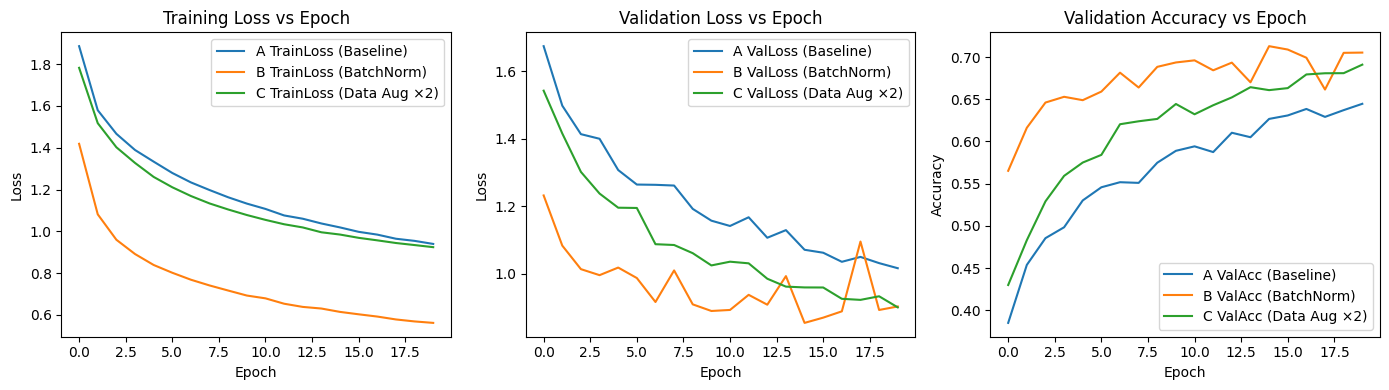

In [15]:
# —— 作用：将 (A)(B)(C) 三个模型的训练损失、验证损失、验证准确率分别画在三张图里并比较 —— #
# —— 依据：题面 Q1(e) 要求绘制三类曲线并基于图形做评论:contentReference[oaicite:12]{index=12} —— #

# 1) 画训练损失曲线（A、B、C）
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(A_train_losses, label="A TrainLoss (Baseline)")
plt.plot(B_train_losses, label="B TrainLoss (BatchNorm)")
plt.plot(C_train_losses, label="C TrainLoss (Data Aug ×2)")
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 2) 画验证损失曲线（A、B、C）
plt.subplot(1,3,2)
plt.plot(A_val_losses, label="A ValLoss (Baseline)")
plt.plot(B_val_losses, label="B ValLoss (BatchNorm)")
plt.plot(C_val_losses, label="C ValLoss (Data Aug ×2)")
plt.title("Validation Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 3) 画验证准确率曲线（A、B、C）
plt.subplot(1,3,3)
plt.plot(A_val_accs, label="A ValAcc (Baseline)")
plt.plot(B_val_accs, label="B ValAcc (BatchNorm)")
plt.plot(C_val_accs, label="C ValAcc (Data Aug ×2)")
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ——（供你写作业报告的要点提示）——
# 预期常见观察：
# * BN（B）通常能让训练更稳定，对学习率不敏感，验证损失与准确率往往优于基线（尤其早期收敛更快）。
# * 数据增强（C）由于“扩容×2”，常能显著降低过拟合，使得验证准确率提升、验证损失下降，尤其在后期 epoch 更明显。
# * 若出现 C 训练损失略高但验证指标更好，属正则化的典型特征（训练更难、泛化更好）。
# 注意：不同硬件/随机种子/num_workers 设置下，曲线细节会有差异，整体趋势才是比较重点。


From the three plots above (Training Loss, Validation Loss, and Validation Accuracy vs Epoch), we can conclude the following:

Baseline Model (A)

Both training and validation losses decrease steadily, and the final validation accuracy reaches around 0.64.

Without any regularization, the model learns slower and shows mild overfitting near the end (validation loss stops improving while training loss continues to decrease).

Batch Normalization Model (B)

The training loss drops significantly faster in the early epochs, reaching the same accuracy as (A) within 5 epochs.

Both curves are smoother and more stable, indicating that batch normalization stabilizes gradient flow and accelerates convergence.

The final validation accuracy (~0.70–0.71) is about 6 percentage points higher than the baseline.

Data Augmentation Model (C)

Because of doubled training data and added random transformations, the training loss remains slightly higher (harder to fit) but the validation accuracy improves to about 0.69.

This shows that data augmentation effectively reduces overfitting and enhances generalization.

Overall Comparison

Batch Normalization (B) improves optimization stability and convergence speed.

Data Augmentation (C) improves generalization and robustness.

A combination of both methods would typically yield the best overall performance.
